In [5]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt

# Connexion à MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['olist_database']

# Création des bases de données et collections via mongodb

### Chargement des fichiers CSV dans MongoDB

In [6]:
csv_files = {
    "customers": "Data/olist_customers_dataset.csv",
    "order_items": "Data/olist_order_items_dataset.csv",
    "order_payments": "Data/olist_order_payments_dataset.csv",
    "order_reviews": "Data/olist_order_reviews_dataset.csv",
    "orders": "Data/olist_orders_dataset.csv",
    "products": "Data/olist_products_dataset.csv",
    "sellers": "Data/olist_sellers_dataset.csv",
    "product_translation": "Data/product_category_name_translation.csv"
}

for collection_name, file_path in csv_files.items():
    df = pd.read_csv(file_path)
    db[collection_name].delete_many({})  
    db[collection_name].insert_many(df.to_dict("records"))
    print(f"Collection '{collection_name}' chargée.")

Collection 'customers' chargée.
Collection 'order_items' chargée.
Collection 'order_payments' chargée.
Collection 'order_reviews' chargée.
Collection 'orders' chargée.
Collection 'products' chargée.
Collection 'sellers' chargée.
Collection 'product_translation' chargée.


### Création d'index 

In [7]:
for collection_name in csv_files.keys():
    collection = db[collection_name]
    df = pd.DataFrame(list(collection.find().limit(1))) 
    for column in df.columns:
        if column != "_id":
            collection.create_index(column)

print("Index créés pour toutes les collections.")

Index créés pour toutes les collections.


# Analyses des données

### Question 1 : Quel est le prix moyen des articles par catégorie de produit ?

In [91]:

order_items_collection = db['order_items']
products_collection = db['products']
product_translation_collection = db['product_translation']

df_order_items = pd.DataFrame(list(order_items_collection.find({}, {"_id": 0, "product_id": 1, "price": 1})))
df_products = pd.DataFrame(list(products_collection.find({}, {"_id": 0, "product_id": 1, "product_category_name": 1})))
df_translation = pd.DataFrame(list(product_translation_collection.find({}, {"_id": 0, "product_category_name": 1, "product_category_name_english": 1})))

df = pd.merge(df_order_items, df_products, on="product_id", how="inner")
df = pd.merge(df, df_translation, on="product_category_name", how="inner")

df_grouped = df.groupby("product_category_name_english")[["price"]].mean().sort_values(by="price", ascending=False).head(10)

print("Prix moyen des articles par catégorie de produit (Top 10):")
print(df_grouped)


Prix moyen des articles par catégorie de produit (Top 10):
                                             price
product_category_name_english                     
computers                              1098.340542
small_appliances_home_oven_and_coffee   624.285658
home_appliances_2                       476.124958
agro_industry_and_commerce              342.124858
musical_instruments                     281.616000
small_appliances                        280.778468
fixed_telephony                         225.693182
construction_tools_safety               208.992371
watches_gifts                           201.135984
air_conditioning                        185.269226


### 1. Visualisation 

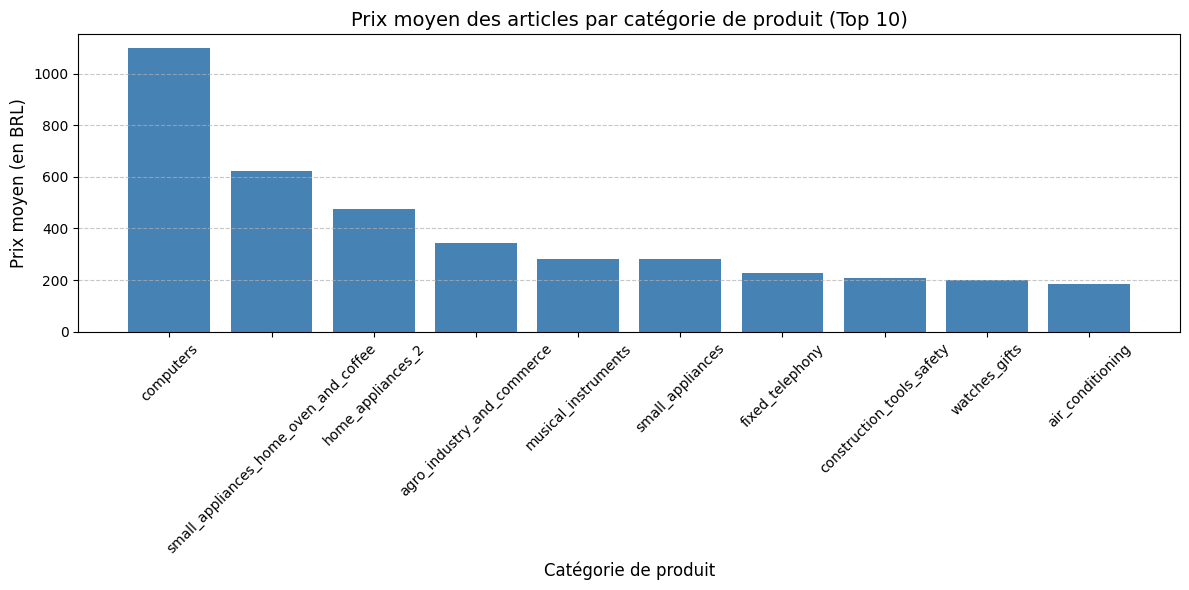

In [94]:
plt.figure(figsize=(12, 6))
plt.bar(df_grouped.index, df_grouped['price'], color='steelblue')
plt.title('Prix moyen des articles par catégorie de produit (Top 10)', fontsize=14)
plt.xlabel('Catégorie de produit', fontsize=12)
plt.ylabel('Prix moyen (en BRL)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [48]:
order_items_collection = db['order_items']
reviews_collection = db['order_reviews']
sellers_collection = db['sellers']


df_order_items = pd.DataFrame(list(order_items_collection.find({}, {"_id": 0, "order_id": 1, "seller_id": 1})))
df_reviews = pd.DataFrame(list(reviews_collection.find({}, {"_id": 0, "order_id": 1, "review_score": 1})))
df_sellers = pd.DataFrame(list(sellers_collection.find({}, {"_id": 0, "seller_id": 1, "seller_city": 1})))

df = pd.merge(df_order_items, df_reviews, on="order_id", how="inner")
df = pd.merge(df, df_sellers, on="seller_id", how="inner")

df_grouped = df.groupby("seller_id").agg(
    avg_review_score=("review_score", "mean"),
    total_orders=("order_id", "count")
).sort_values(by="avg_review_score", ascending=False).head(10)

print("\nTop 10 des vendeurs par score moyen de satisfaction et nombre de commandes :")
print(df_grouped)

print("\nInterprétation :")
for index, row in df_grouped.iterrows():
    print(f"Vendeur {index}: Score moyen = {row['avg_review_score']:.2f}, Nombre de commandes = {row['total_orders']}")


Top 10 des vendeurs par score moyen de satisfaction et nombre de commandes :
                                  avg_review_score  total_orders
seller_id                                                       
feb793c88d836c3a75efa4b5a3465d70               5.0             1
e59e575a175fadcadf8479e191770425               5.0             1
e595809a6c31ec4314fd06ef198c244d               5.0             1
e560e4022d8f7aebf155db95946c5c0f               5.0             2
e5545d4d4473876ea78c5bcebca365c3               5.0             1
392f7f2c797e4dc077e4311bde2ab8ce               5.0             2
333c4210e76a1aa2ab817b99437e3ff1               5.0             2
32f83ffe11cd40f7adcf4eef171f52d9               5.0             1
32e5635e63cb374eb63afdd242fb6134               5.0             1
38f276ca6e7cc95a6d1bb55ac9e5550f               5.0             1

Interprétation :
Vendeur feb793c88d836c3a75efa4b5a3465d70: Score moyen = 5.00, Nombre de commandes = 1.0
Vendeur e59e575a175fadcadf8479e19177

### 2. Visualisation 

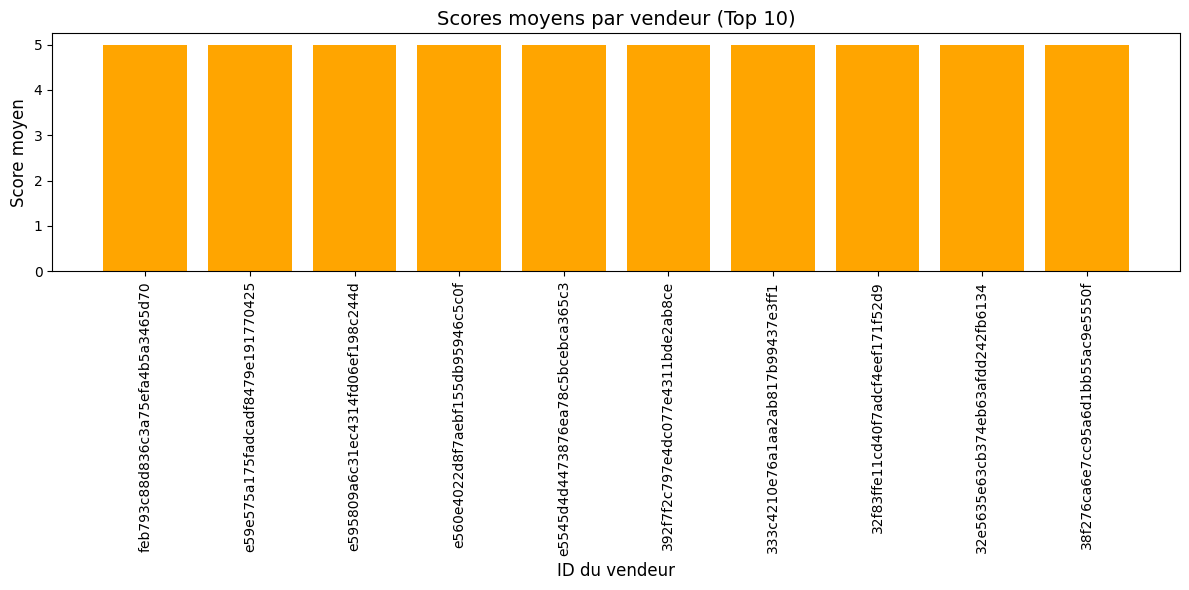

In [53]:
plt.figure(figsize=(12, 6))
plt.bar(df_grouped.index, df_grouped['avg_review_score'], color='orange')
plt.title('Scores moyens par vendeur (Top 10)', fontsize=14)
plt.xlabel('ID du vendeur', fontsize=12)
plt.ylabel('Score moyen', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle=' ', alpha=0.7)
plt.show()

### Question 3 : Délai moyen de livraison des commandes

In [54]:
orders_collection = db['orders']
df_orders = pd.DataFrame(list(orders_collection.find({}, {"_id": 0, "order_purchase_timestamp": 1, "order_delivered_customer_date": 1})))


df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])
df_orders['order_delivered_customer_date'] = pd.to_datetime(df_orders['order_delivered_customer_date'])


df_orders['delivery_delay'] = (df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp']).dt.days

# Calcul du délai moyen de livraison
delivery_delay_mean = df_orders['delivery_delay'].mean()
print(f"Délai moyen de livraison chez Olist : {delivery_delay_mean:.2f} jours")

Délai moyen de livraison chez Olist : 12.09 jours


In [19]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import seaborn as sns

### 3. Visualisation : Distribution des délais de livraison

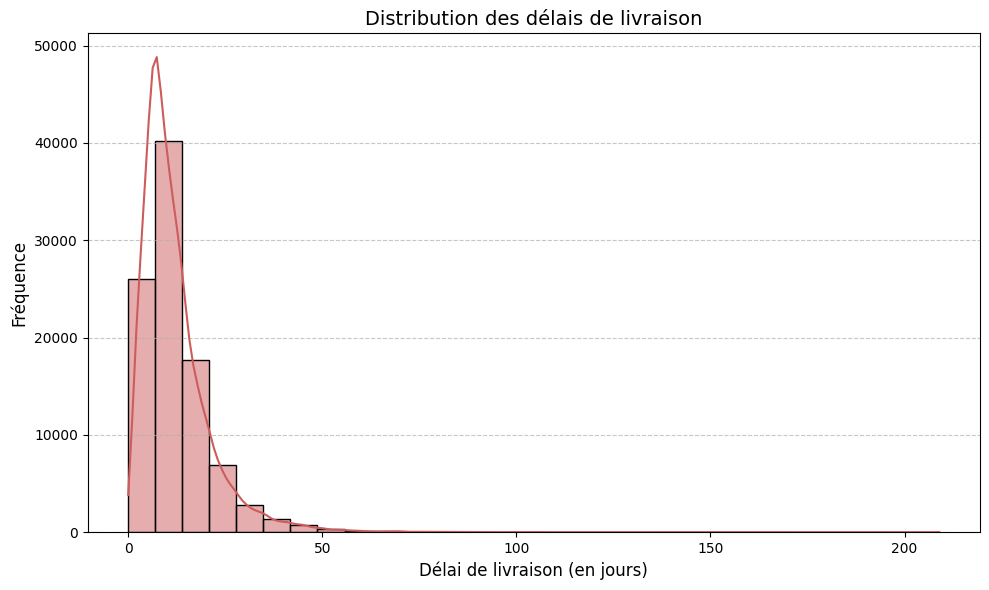

In [82]:
plt.figure(figsize=(10, 6))
sns.histplot(df_orders['delivery_delay'].dropna(), kde=True, color='indianred', bins=30)
plt.title('Distribution des délais de livraison', fontsize=14)
plt.xlabel('Délai de livraison (en jours)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Question 4 : Quels sont les 7 états les plus prolifiques pour Olist ?

In [57]:
customers_collection = db['customers']
df_customers = pd.DataFrame(list(customers_collection.find({}, {"_id": 0, "customer_state": 1})))


In [58]:

top_states = df_customers['customer_state'].value_counts().sort_values(ascending=True).tail(7)

print("Top 7 des états les plus prolifiques pour Olist (par ordre croissant) :")
print(top_states)

Top 7 des états les plus prolifiques pour Olist (par ordre croissant) :
customer_state
BA     3380
SC     3637
PR     5045
RS     5466
MG    11635
RJ    12852
SP    41746
Name: count, dtype: int64


In [24]:
# Sauvegarde dans une nouvelle collection
collection_top_states = db['top_etats']
collection_top_states.delete_many({})  

data_to_save = [{"state": state, "count": count} for state, count in top_states.items()]
collection_top_states.insert_many(data_to_save)
print("Résultats sauvegardés dans la collection 'top_etats'.")

Résultats sauvegardés dans la collection 'top_etats'.


### 4. Visualisation 

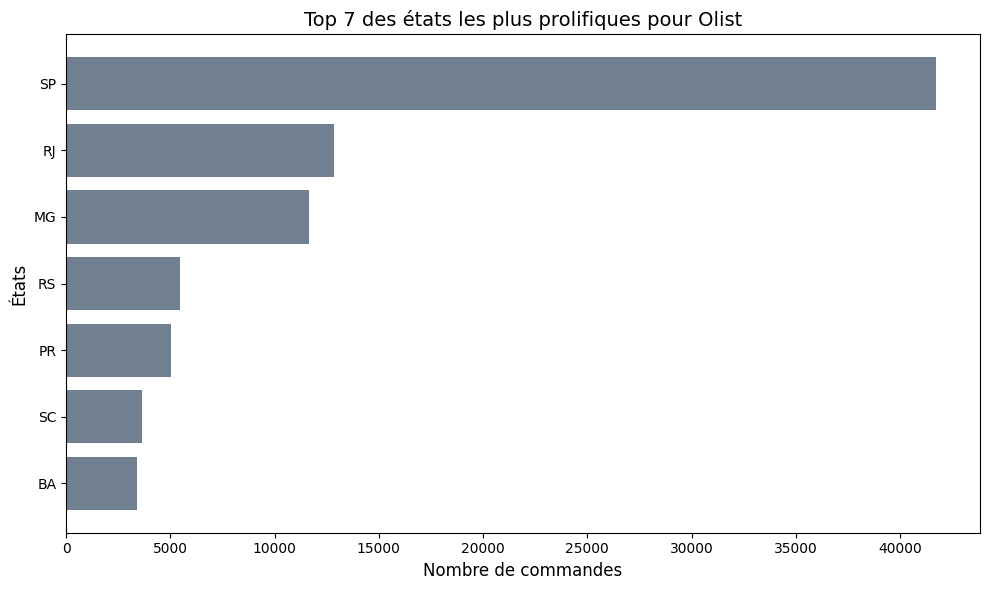

In [78]:
plt.figure(figsize=(10, 6))
plt.barh(top_states.index, top_states.values, color='slategray')
plt.title('Top 7 des états les plus prolifiques pour Olist', fontsize=14)
plt.xlabel('Nombre de commandes', fontsize=12)
plt.ylabel('États', fontsize=12)
plt.grid(axis='x', linestyle=' ', alpha=0.7)
plt.tight_layout()
plt.show()

### Question 5 : Quels sont les 7 premiers états dont le délai de livraison est plus court ?

In [59]:
customers_collection = db['customers']
orders_collection = db['orders']

# Charger les données nécessaires
df_customers = pd.DataFrame(list(customers_collection.find({}, {"_id": 0, "customer_id": 1, "customer_state": 1})))
df_orders = pd.DataFrame(list(orders_collection.find({}, {"_id": 0, "customer_id": 1, "order_purchase_timestamp": 1, "order_delivered_customer_date": 1})))

In [61]:
# Convertir les colonnes en format datetime
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])
df_orders['order_delivered_customer_date'] = pd.to_datetime(df_orders['order_delivered_customer_date'])


df_orders['delivery_delay'] = (df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp']).dt.days
df = pd.merge(df_orders, df_customers, on="customer_id", how="inner")

# Calculer le délai moyen de livraison par état
delivery_delay_by_state = df.groupby("customer_state")["delivery_delay"].mean().sort_values().head(7)

print("Top 7 des états avec le délai de livraison le plus court :")
print(delivery_delay_by_state)

Top 7 des états avec le délai de livraison le plus court :
customer_state
SP     8.298061
PR    11.526711
MG    11.543813
DF    12.509135
SC    14.479560
RS    14.819237
RJ    14.849186
Name: delivery_delay, dtype: float64


In [29]:
collection_top_states = db['top_etats']
existing_states = pd.DataFrame(list(collection_top_states.find({}, {"_id": 0})))


data_to_save = []
for state, delay in delivery_delay_by_state.items():
    if not existing_states.empty and state in existing_states['state'].values:
        continue  
    data_to_save.append({"state": state, "delivery_delay_mean": delay})

if data_to_save:
    collection_top_states.insert_many(data_to_save)
print("Résultats sauvegardés dans la collection 'top_etats'.")

Résultats sauvegardés dans la collection 'top_etats'.


### 5. Visualisation 

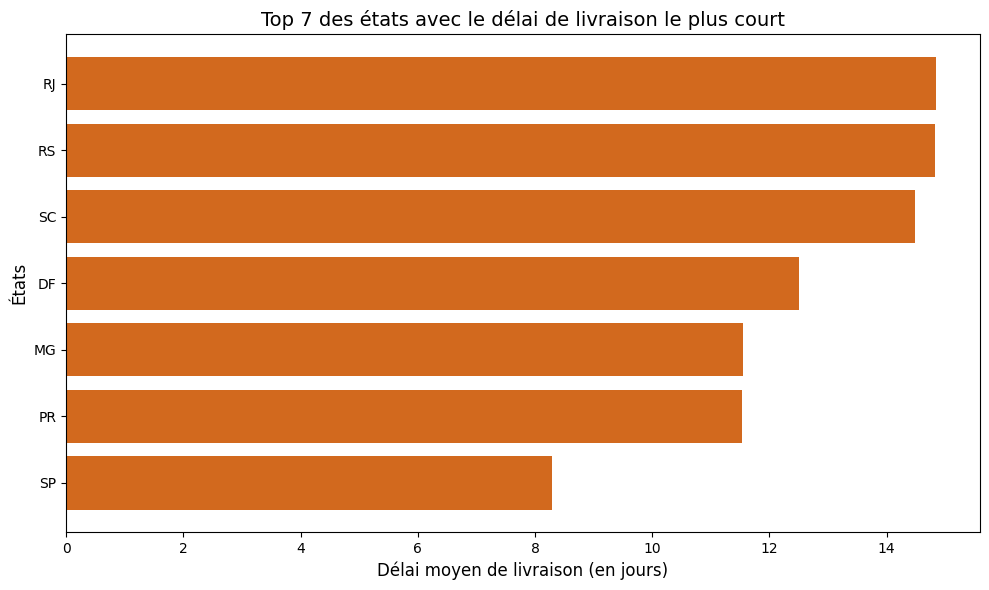

In [77]:
plt.figure(figsize=(10, 6))
plt.barh(delivery_delay_by_state.index, delivery_delay_by_state.values, color='chocolate')
plt.title('Top 7 des états avec le délai de livraison le plus court', fontsize=14)
plt.xlabel('Délai moyen de livraison (en jours)', fontsize=12)
plt.ylabel('États', fontsize=12)
plt.grid(axis='x', linestyle=' ', alpha=0.7)
plt.tight_layout()
plt.show()

### Question 6 : Quelle est la catégorie de produit la mieux notée ?

In [63]:
order_items_collection = db['order_items']
reviews_collection = db['order_reviews']
products_collection = db['products']
product_translation_collection = db['product_translation']


df_order_items = pd.DataFrame(list(order_items_collection.find({}, {"_id": 0, "product_id": 1, "order_id": 1})))
df_reviews = pd.DataFrame(list(reviews_collection.find({}, {"_id": 0, "order_id": 1, "review_score": 1})))
df_products = pd.DataFrame(list(products_collection.find({}, {"_id": 0, "product_id": 1, "product_category_name": 1})))
df_translation = pd.DataFrame(list(product_translation_collection.find({}, {"_id": 0, "product_category_name": 1, "product_category_name_english": 1})))


df = pd.merge(df_order_items, df_reviews, on="order_id", how="inner")
df = pd.merge(df, df_products, on="product_id", how="inner")
df = pd.merge(df, df_translation, on="product_category_name", how="inner")


df_grouped = df.groupby("product_category_name_english")["review_score"].mean().sort_values(ascending=False).head(10)

# Affichage des résultats
print("Top 10 des catégories de produits les mieux notées :")
print(df_grouped)


Top 10 des catégories de produits les mieux notées :
product_category_name_english
cds_dvds_musicals                        4.642857
fashion_childrens_clothes                4.500000
books_general_interest                   4.446266
costruction_tools_tools                  4.444444
flowers                                  4.419355
books_imported                           4.400000
books_technical                          4.368421
food_drink                               4.315412
luggage_accessories                      4.315257
small_appliances_home_oven_and_coffee    4.302632
Name: review_score, dtype: float64


In [64]:
# Calcul de la moyenne des notes par catégorie de produit
df_grouped = df.groupby("product_category_name_english")["review_score"].mean().sort_values(ascending=False)

# Affichage de la catégorie de produit la mieux notée

best_category = df_grouped.idxmax()
best_score = df_grouped.max()
print(f"La catégorie de produit la mieux notée est '{best_category}' avec un score moyen de {best_score:.2f}.")



La catégorie de produit la mieux notée est 'cds_dvds_musicals' avec un score moyen de 4.64.


# 6 Visualisation 

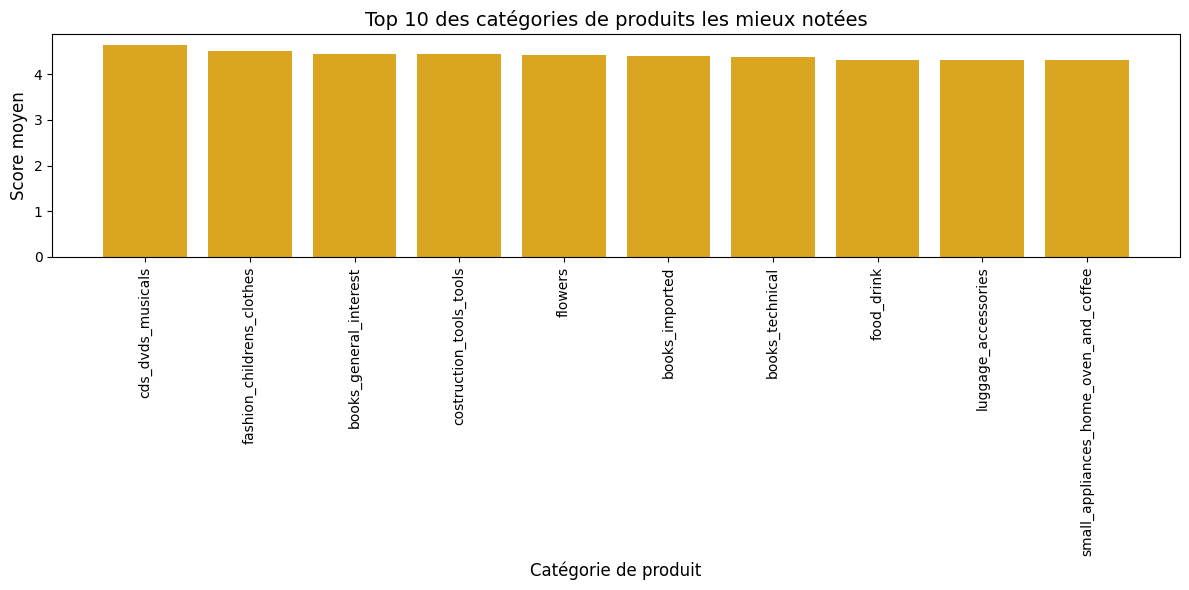

In [76]:
plt.figure(figsize=(12, 6))
plt.bar(df_grouped.head(10).index, df_grouped.head(10).values, color='goldenrod')
plt.title('Top 10 des catégories de produits les mieux notées', fontsize=14)
plt.xlabel('Catégorie de produit', fontsize=12)
plt.ylabel('Score moyen', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle=' ', alpha=0.7)
plt.show()